# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv


Якщо не вдається завантажиит з Kaggle, ось тут можна - https://drive.google.com/file/d/1kfu5zCRsDHxoBZigBlGIcCieKlws02HT/view?usp=sharing

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

Увага! В цьому наборі завдань для простоти експериментів ми будемо спочатку робити векторизацію на всьому наборі даних, а потім розбивку на train i test. В робочих проєктах ми теж можемо використати цей підхід для швидшої побудови PoC (proof of concept). Але фінальне рішення, яке ми будемо деплоїти - треба проводити за правилом - спочатку розбивка на трейн і тест, потім пишемо обробку для трейну, навчаємо векторизатори. І потім використовуємо готові векторизатори для тесту і всіх даних на етапі передбачення (інференсу).

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

pd.set_option("display.max_colwidth", 150)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sofiapetrova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("train 2.csv")

df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [4]:
df.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [5]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative


In [6]:
df = df.dropna()

In [7]:
df.isnull().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [8]:
sent_count = df["sentiment"].value_counts()

sent_count

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

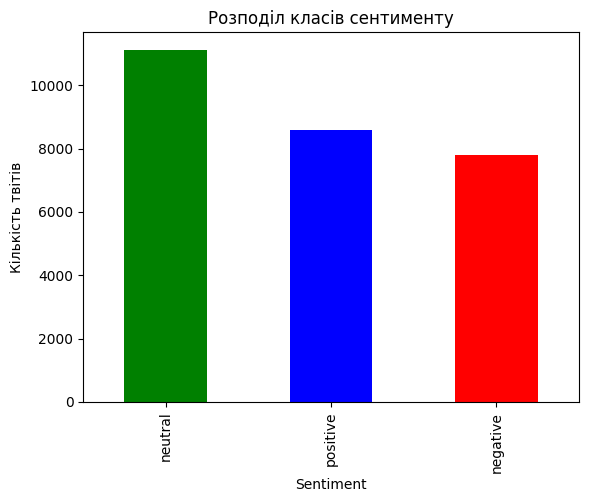

In [9]:
sent_count.plot(kind="bar", color=["green", "blue", "red"])
plt.title("Розподіл класів сентименту")
plt.xlabel("Sentiment")
plt.ylabel("Кількість твітів")
plt.show()

**Клас neutral зустрічається найчастіше, дані трохи незбалансовані, тож класифікатор може схилятися до прогнозування саме neutral сентименту.**

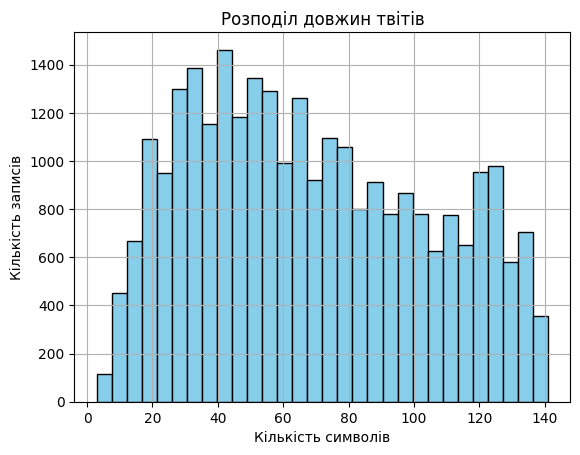

count    27480.000000
mean        68.330022
std         35.603870
min          3.000000
25%         39.000000
50%         64.000000
75%         97.000000
max        141.000000
Name: text_length, dtype: float64

In [10]:
df["text_length"] = df["text"].apply(len)
df["text_length"].hist(bins=30, color="skyblue", edgecolor="black")
plt.title("Розподіл довжин твітів")
plt.xlabel("Кількість символів")
plt.ylabel("Кількість записів")
plt.show()

df["text_length"].describe()

**Найбільше коротких повідомлень (30–70 символів) як і типово для Twitter. Середня довжина твіту ≈ 68 символів. 50% твітів коротші за 64 символи, а 75% - коротші за 97 символів. Нема потреби у складній обробці довгих послідовностей.**

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [11]:
stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

def preprocess_text(text):
    text = text.lower()                              
    text = re.sub(r'[^a-z\s]', '', text)             
    tokens = text.split()                          
    tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df["clean_text"] = df["text"].apply(preprocess_text)
df[["text", "clean_text"]].head()

,text,clean_text
0,"I`d have responded, if I were going",id respond go
1,Sooo SAD I will miss you here in San Diego!!!,sooo sad miss san diego
2,my boss is bullying me...,boss bulli
3,what interview! leave me alone,interview leav alon
4,"Sons of ****, why couldn`t they put them on the releases we already bought",son couldnt put releas alreadi bought


In [12]:
cv_full = CountVectorizer()
X_full = cv_full.fit_transform(df["clean_text"])

words = cv_full.get_feature_names_out()
word_counts = X_full.sum(axis=0).A1  
freq_df = pd.DataFrame({"word": words, "count": word_counts}).sort_values("count", ascending=False)
print("Усього унікальних слів:", len(freq_df))
freq_df.head()

Усього унікальних слів: 22746


,word,count
10105,im,3059
4470,day,2414
7366,go,2363
7190,get,1909
7425,good,1569


In [13]:
freq_df["count"].describe()

count    22746.000000
mean         8.633430
std         58.143549
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       3059.000000
Name: count, dtype: float64

**Більшість слів зустрічаються 1–2 рази, тобто майже не допомагають класифікатору, але “зашумлюють” модель.**

In [14]:
freq_df["cum_sum"] = freq_df["count"].cumsum()
freq_df["coverage"] = freq_df["cum_sum"] / freq_df["count"].sum()

freq_df.head(20)

,word,count,cum_sum,coverage
10105,im,3059,3059,0.015577
4470,day,2414,5473,0.027870
7366,go,2363,7836,0.039903
7190,get,1909,9745,0.049624
7425,good,1569,11314,0.057614
22049,work,1483,12797,0.065166
12071,love,1458,14255,0.072590
11745,like,1454,15709,0.079995
5124,dont,1202,16911,0.086115
19939,today,1115,18026,0.091793


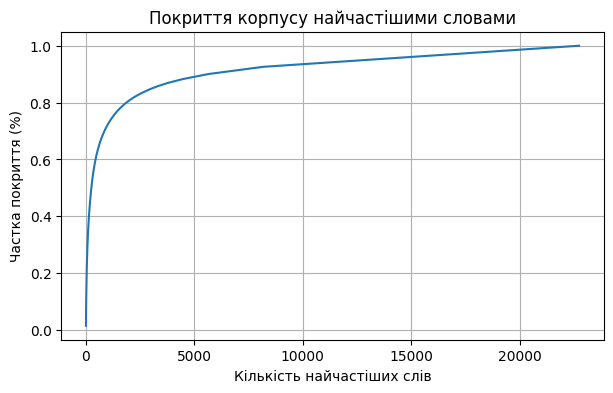

In [15]:
plt.figure(figsize=(7,4))
plt.plot(range(1, len(freq_df)+1), freq_df["coverage"])
plt.title("Покриття корпусу найчастішими словами")
plt.xlabel("Кількість найчастіших слів")
plt.ylabel("Частка покриття (%)")
plt.grid(True)
plt.show()

**5000 слів виглядає найбільш оптимальним варіантом.**

In [16]:
vectorizer_bow = CountVectorizer(max_features=5000)
X_bow = vectorizer_bow.fit_transform(df["clean_text"])
X_bow.shape

(27480, 5000)

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [17]:
enc = OrdinalEncoder()
df["sentiment_encoded"] = enc.fit_transform(df[["sentiment"]])

y = df["sentiment_encoded"]

X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    X_bow, y, test_size=0.2, random_state=42, stratify=y
)

print("Розмір X_train:", X_train_bow.shape)
print("Розмір X_test:", X_test_bow.shape)

Розмір X_train: (21984, 5000)
Розмір X_test: (5496, 5000)


In [18]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
}


results = []

for name, model in models.items():
    print(f"\n Навчання моделі: {name}")
    model.fit(X_train_bow, y_train)
    y_pred = model.predict(X_test_bow)
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))
    print(f"Accuracy = {acc:.4f}")


results_df = pd.DataFrame(results, columns=["Model", "Accuracy"]).sort_values("Accuracy", ascending=False)
print("\n Порівняння точності моделей:")
display(results_df)


best_model_name = results_df.iloc[0, 0]
best_model = models[best_model_name]
print(f"\n Найкраща модель: {best_model_name}\n")

y_pred_best = best_model.predict(X_test_bow)
print(classification_report(y_test, y_pred_best, target_names=enc.categories_[0]))


 Навчання моделі: Logistic Regression
Accuracy = 0.6889

 Навчання моделі: Decision Tree
Accuracy = 0.6275

 Навчання моделі: Random Forest
Accuracy = 0.6890

 Навчання моделі: XGBoost
Accuracy = 0.6936

 Порівняння точності моделей:


,Model,Accuracy
3,XGBoost,0.693595
2,Random Forest,0.689047
0,Logistic Regression,0.688865
1,Decision Tree,0.627547



 Найкраща модель: XGBoost

              precision    recall  f1-score   support

    negative       0.76      0.56      0.64      1556
     neutral       0.62      0.79      0.69      2223
    positive       0.77      0.70      0.73      1717

    accuracy                           0.69      5496
   macro avg       0.72      0.68      0.69      5496
weighted avg       0.71      0.69      0.69      5496



In [19]:
train_test_results = []

for name, model in models.items():
    model.fit(X_train_bow, y_train)
    
    y_pred_train = model.predict(X_train_bow)
    y_pred_test = model.predict(X_test_bow)
    
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    
    train_test_results.append((name, acc_train, acc_test))


train_test_df = pd.DataFrame(train_test_results, columns=["Model", "Train Accuracy", "Test Accuracy"])
train_test_df["Diff"] = train_test_df["Train Accuracy"] - train_test_df["Test Accuracy"]
display(train_test_df.sort_values("Diff", ascending=False))

,Model,Train Accuracy,Test Accuracy,Diff
1,Decision Tree,0.992813,0.627547,0.365266
2,Random Forest,0.992813,0.689047,0.303766
0,Logistic Regression,0.815775,0.688865,0.126910
3,XGBoost,0.741767,0.693595,0.048171


**Побудовано чотири моделі класифікації, найвищу точність показала модель XGBoost. Класи neutral і positive розпізнаються найкраще, тоді як negative частіше плутається з нейтральними твітами. Отримані результати більш-менш задовільні для базового рівня класифікації твітів.**

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [20]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_bow, y_train)


feature_names = np.array(vectorizer_bow.get_feature_names_out())


coeffs = log_reg.coef_


for i, class_label in enumerate(enc.categories_[0]):  # ['negative', 'neutral', 'positive']
    sorted_idx = np.argsort(coeffs[i])
    top10 = feature_names[sorted_idx[-10:]]
    bottom10 = feature_names[sorted_idx[:10]]
    
    print(f"\n🔹 Найвпливовіші слова для класу '{class_label}':")
    print("  + Позитивно впливають на передбачення цього класу:")
    print("    ", ", ".join(top10))
    print("  - Негативно (характерні для протилежних класів):")
    print("    ", ", ".join(bottom10))


🔹 Найвпливовіші слова для класу 'negative':
  + Позитивно впливають на передбачення цього класу:
     exhaust, worst, stupid, miss, fail, hate, sorri, bore, suck, sad
  - Негативно (характерні для протилежних класів):
     awesom, glad, love, beauti, thank, cute, welcom, enjoy, amaz, great

🔹 Найвпливовіші слова для класу 'neutral':
  + Позитивно впливають на передбачення цього класу:
     starwarsday, jst, httptwitpiccomhac, moro, sp, parvo, oooo, otherwis, how, indoor
  - Негативно (характерні для протилежних класів):
     forum, wtf, incred, thrill, product, congratul, impati, proud, truli, migrain

🔹 Найвпливовіші слова для класу 'positive':
  + Позитивно впливають на передбачення цього класу:
     great, excit, nice, enjoy, glad, amaz, love, thank, cute, awesom
  - Негативно (характерні для протилежних класів):
     sad, shame, sorri, suck, bore, horribl, hate, miss, jealous, tire


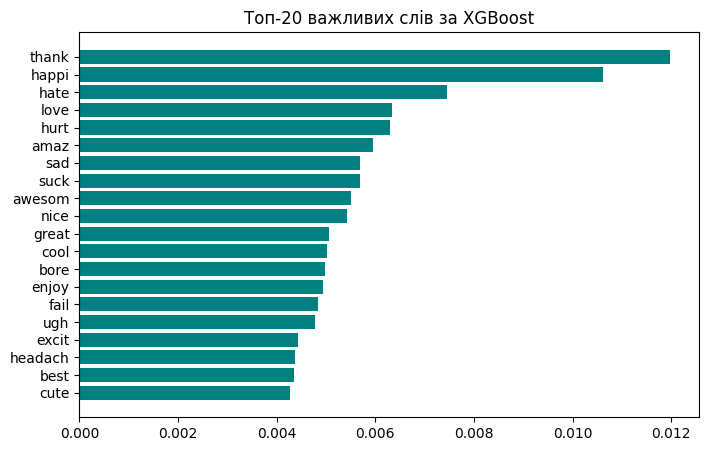

In [21]:
importance = best_model.feature_importances_

xgb_importance = pd.DataFrame({
    "word": vectorizer_bow.get_feature_names_out(),
    "importance": importance
}).sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(8,5))
plt.barh(xgb_importance["word"], xgb_importance["importance"], color="teal")
plt.gca().invert_yaxis()
plt.title("Топ-20 важливих слів за XGBoost")
plt.show()

**У positive домінують слова з яскравим позитивним забарвленням, у negative — класичні негативні маркери, у neutral — спокійні слова, без емоційного змісту. Виглядає цлком логічно, тобто модель справді вловлює емоційну лексику. Аналіз важливості ознак у XGBoost підтверджує, що ті самі токени мають найбільший внесок у рішення моделі.**

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [22]:
vectorizer_tfidf = TfidfVectorizer(max_features=5000)  
X_tfidf = vectorizer_tfidf.fit_transform(df["clean_text"])

X_tfidf.shape

(27480, 5000)

In [23]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
models_tfidf = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
}

results_tfidf = []

for name, model in models_tfidf.items():
    print(f"\n Навчання моделі (TF-IDF): {name}")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    results_tfidf.append((name, acc))
    print(f"Accuracy = {acc:.4f}")

results_tfidf_df = pd.DataFrame(results_tfidf, columns=["Model", "Accuracy"]).sort_values("Accuracy", ascending=False)
print("\n Порівняння точності моделей (TF-IDF):")
display(results_tfidf_df)


 Навчання моделі (TF-IDF): Logistic Regression
Accuracy = 0.6883

 Навчання моделі (TF-IDF): Decision Tree
Accuracy = 0.6436

 Навчання моделі (TF-IDF): Random Forest
Accuracy = 0.6965

 Навчання моделі (TF-IDF): XGBoost
Accuracy = 0.6872

 Порівняння точності моделей (TF-IDF):


,Model,Accuracy
2,Random Forest,0.696507
0,Logistic Regression,0.688319
3,XGBoost,0.687227
1,Decision Tree,0.643559


In [25]:
best_model_name_tfidf = results_tfidf_df.iloc[0, 0]
best_model_tfidf = models_tfidf[best_model_name_tfidf]

print(f"\n Найкраща модель (TF-IDF): {best_model_name_tfidf}\n")
y_pred_tfidf = best_model_tfidf.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_tfidf, target_names=enc.categories_[0]))


 Найкраща модель (TF-IDF): Random Forest

              precision    recall  f1-score   support

    negative       0.72      0.62      0.67      1556
     neutral       0.65      0.72      0.68      2223
    positive       0.75      0.74      0.74      1717

    accuracy                           0.70      5496
   macro avg       0.71      0.69      0.70      5496
weighted avg       0.70      0.70      0.70      5496



In [26]:
train_test_results_tfidf = []

for name, model in models_tfidf.items():
    print(f"\n Навчання моделі (TF-IDF): {name}")
    model.fit(X_train_tfidf, y_train)

    y_pred_train = model.predict(X_train_tfidf)
    y_pred_test = model.predict(X_test_tfidf)
    
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    
    train_test_results_tfidf.append((name, acc_train, acc_test))

train_test_df_tfidf = pd.DataFrame(train_test_results_tfidf, columns=["Model", "Train Accuracy", "Test Accuracy"])
train_test_df_tfidf["Diff"] = train_test_df_tfidf["Train Accuracy"] - train_test_df_tfidf["Test Accuracy"]

display(train_test_df_tfidf.sort_values("Diff", ascending=False))



 Навчання моделі (TF-IDF): Logistic Regression

 Навчання моделі (TF-IDF): Decision Tree

 Навчання моделі (TF-IDF): Random Forest

 Навчання моделі (TF-IDF): XGBoost


,Model,Train Accuracy,Test Accuracy,Diff
1,Decision Tree,0.992722,0.643559,0.349163
2,Random Forest,0.992722,0.696507,0.296215
0,Logistic Regression,0.776110,0.688319,0.087791
3,XGBoost,0.758597,0.687227,0.071370


In [27]:
log_reg_tfidf = LogisticRegression(max_iter=1000)
log_reg_tfidf.fit(X_train_tfidf, y_train)

feature_names_tfidf = np.array(vectorizer_tfidf.get_feature_names_out())
coeffs_tfidf = log_reg_tfidf.coef_

for i, class_label in enumerate(enc.categories_[0]):
    sorted_idx = np.argsort(coeffs_tfidf[i])
    top10 = feature_names_tfidf[sorted_idx[-10:]]
    bottom10 = feature_names_tfidf[sorted_idx[:10]]
    
    print(f"\n🔹 Найвпливовіші слова для класу '{class_label}' (TF-IDF):")
    print("  + Сильний позитивний вплив:", ", ".join(top10))
    print("  - Сильний негативний вплив:", ", ".join(bottom10))


🔹 Найвпливовіші слова для класу 'negative' (TF-IDF):
  + Сильний позитивний вплив: tire, stupid, hurt, fail, bore, hate, suck, sorri, miss, sad
  - Сильний негативний вплив: love, thank, awesom, hope, glad, great, nice, enjoy, cute, amaz

🔹 Найвпливовіші слова для класу 'neutral' (TF-IDF):
  + Сильний позитивний вплив: relat, werent, except, jst, otherwis, differ, moro, guitar, indoor, how
  - Сильний негативний вплив: happi, good, fail, stupid, thank, nice, amaz, excit, funni, wtf

🔹 Найвпливовіші слова для класу 'positive' (TF-IDF):
  + Сильний позитивний вплив: enjoy, amaz, hope, good, happi, nice, great, awesom, thank, love
  - Сильний негативний вплив: miss, sad, sorri, suck, tire, hate, bore, shame, bad, sick


**Найвищу точність показала модель Random Forest, дещо перевищила результати BoW, проте доволі сильно переобучена. TF-IDF дозволив зменшити вагу часто вживаних слів і посилити вплив більш змістовних токенів. Negative вже не так сильно плутається з нейтральними твітами. Отже, TF-IDF забезпечує кращу узагальнювальну здатність і точність при тій самій кількості ознак, тому його доцільно обрати для фінальної імплементації рішення.**

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [28]:
y_pred_tfidf = best_model_tfidf.predict(X_test_tfidf)


errors = X_test_tfidf.shape[0]
error_mask = (y_pred_tfidf != y_test)


errors_df = pd.DataFrame({
    "text": df.loc[y_test.index, "text"],  
    "true_label": enc.inverse_transform(y_test.values.reshape(-1, 1)).ravel(),
    "pred_label": enc.inverse_transform(y_pred_tfidf.reshape(-1, 1)).ravel()
})


errors_df = errors_df[errors_df["true_label"] != errors_df["pred_label"]]


errors_df.sample(10, random_state=42)

,text,true_label,pred_label
27324,is liking this feeling,positive,negative
15212,_com Ohhh got it. It`s the 8830 I think I miss the Pistons I really hope Joe D cooks up something big!,neutral,negative
14826,"So there aren`t anymore exams, but there is only 3 days left. I`ve just now relized this is a bad thing. And a good thing. I dont know.",neutral,negative
13566,"oh thas cool you know, I only kinda knew bouts you cuz of Ericson haha when you guys were together x)",neutral,positive
12790,ooooh it`s you lol I didn`t know!! Have fun with your princess,positive,neutral
6018,I`ve lost my pocket knife Suggestions for replacing a Ken Onion Chive?,neutral,negative
25588,"i thought ur account was fake. but, it`s true, sorry david!",neutral,negative
27037,can`t sleep so i`m watching some more Gilmore Girls,neutral,negative
16515,haha I fail just remember sohcahtoa xD,neutral,negative
11368,A message from Could you let people know I have been booted off,negative,neutral


<Figure size 500x400 with 0 Axes>

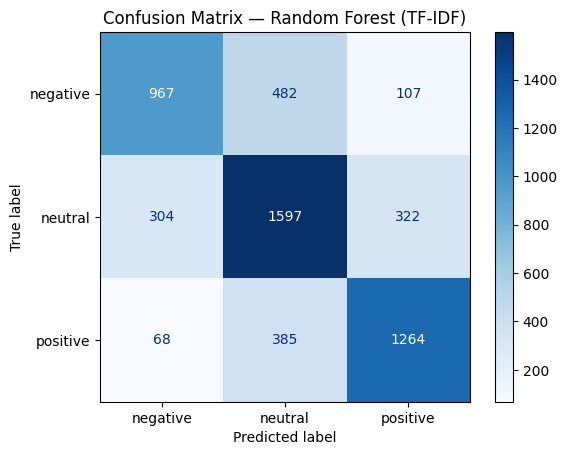

In [29]:
cm = confusion_matrix(y_test, y_pred_tfidf)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=enc.categories_[0]
)
plt.figure(figsize=(5, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Random Forest (TF-IDF)")
plt.show()

**Матриця помилок показує, що найбільше помилок спостерігається між класами negative і neutral (482 випадки) та між positive і neutral (385 випадків). Це свідчить про труднощі моделі у розрізненні висловів зі слабким емоційним забарвленням, коли окремі емоційні слова не змінюють загальний тон повідомлення. Водночас позитивні та негативні твіти з яскраво вираженою емоцією розпізнаються досить добре. Для підвищення якості класифікації можна спробувати використати біграми або тріграми в TF-IDF, що дозволить моделі враховувати краще контекст; перейти до більш просунутих моделей як BERT; застосувати лематизацію замість стемінгу для збереження реальної словоформи та покращення якості ознак.**

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model